In [225]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt 
from sklearn.model_selection import cross_validate
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm_notebook
from collections import Counter
from sklearn.metrics import roc_auc_score
import pickle
pd.set_option('display.max_columns', 500)

In [226]:
train = pd.read_csv("train_users_2.csv")
test = pd.read_csv("test_users.csv")
countries = pd.read_csv("countries.csv")
sessions = pd.read_csv("sessions.csv")
age_gender = pd.read_csv("age_gender_bkts.csv")

In [227]:
train['country_destination'].value_counts()/len(train)

NDF      0.583473
US       0.292226
other    0.047290
FR       0.023532
IT       0.013282
GB       0.010888
ES       0.010536
CA       0.006690
DE       0.004971
NL       0.003570
AU       0.002525
PT       0.001017
Name: country_destination, dtype: float64

In [228]:
labels = train['country_destination'].values
labels

array(['NDF', 'NDF', 'US', ..., 'NDF', 'NDF', 'NDF'], dtype=object)

In [229]:
train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [230]:
train1 = train.drop(['country_destination'], axis=1)

In [231]:
length = len(train1)
test_id = test.id
all_data = pd.concat((train1, test), axis = 0, ignore_index = True)

In [232]:
all_data = all_data.drop(['date_first_booking'], axis=1)

## Feature Engineering

In [233]:
def replace_f(df,columns,threshold):
    dict_={}
    for i,j in dict(df[columns].value_counts()/len(df)).items():
        if j > threshold:
            dict_[i]=i
        else:
            dict_[i]='other'
    df[columns] = df[columns].map(dict_)

concat sessions

In [234]:
#replace_f(sessions,'action_detail',0.01)

In [235]:
mean_sess = sessions.groupby(by=['user_id','action_detail']).mean().reset_index().pivot(index='user_id',columns='action_detail',values='secs_elapsed').reset_index()

In [236]:
mean_sess1 = sessions.groupby(by=['user_id','action_detail']).count().reset_index().pivot(index='user_id',columns='action_detail',values='secs_elapsed').reset_index()

In [237]:
all_data = pd.merge(all_data, mean_sess, left_on='id', right_on ='user_id',how='left')

In [238]:
all_data = pd.merge(all_data, mean_sess1, left_on='id', right_on ='user_id',how='left')

cut created date and first active

In [239]:
all_data = all_data.drop(['id','user_id_x','user_id_y'], axis=1)

In [240]:
all_data.head(1)

,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,-unknown-_x,account_notification_settings_x,account_payment_methods_x,account_payout_preferences_x,account_privacy_settings_x,account_transaction_history_x,admin_templates_x,airbnb_picks_wishlists_x,alteration_field_x,alteration_request_x,apply_coupon_x,apply_coupon_click_x,apply_coupon_click_success_x,apply_coupon_error_x,at_checkpoint_x,book_it_x,booking_x,calculate_worth_x,cancellation_policies_x,cancellation_policy_x,cancellation_policy_click_x,change_availability_x,change_contact_host_dates_x,change_or_alter_x,change_password_x,change_trip_characteristics_x,click_about_host_x,click_amenities_x,click_reviews_x,complete_booking_x,confirm_email_x,confirm_email_link_x,contact_host_x,coupon_code_click_x,coupon_field_focus_x,create_alteration_request_x,create_listing_x,create_payment_instrument_x,create_phone_numbers_x,create_user_x,dashboard_x,deactivate_user_account_x,delete_listing_x,delete_listing_description_x,delete_payment_instrument_x,delete_phone_numbers_x,edit_profile_x,email_wishlist_x,email_wishlist_button_x,forgot_password_x,friends_wishlists_x,guest_cancellation_x,guest_itinerary_x,guest_receipt_x,header_userpic_x,homepage_x,host_guarantee_x,host_home_x,host_refund_guest_x,host_respond_x,host_respond_page_x,host_standard_suspension_x,instant_book_x,list_your_space_x,listing_descriptions_x,listing_recommendations_x,listing_reviews_x,listing_reviews_page_x,login_x,login_modal_x,login_page_x,lookup_message_thread_x,manage_listing_x,message_inbox_x,message_post_x,message_thread_x,message_to_host_change_x,message_to_host_focus_x,modify_reservations_x,modify_users_x,move_map_x,notifications_x,oauth_login_x,oauth_response_x,p1_x,p3_x,p4_x,p4_refund_policy_terms_x,p4_terms_x,p5_x,payment_instruments_x,pending_x,phone_numbers_x,phone_verification_success_x,photos_x,place_worth_x,popular_wishlists_x,post_checkout_action_x,previous_trips_x,profile_references_x,profile_reviews_x,profile_verifications_x,read_policy_click_x,remove_dashboard_alert_x,request_new_confirm_email_x,request_to_book_x,reservations_x,respond_to_alteration_request_x,send_message_x,set_default_payment_instrument_x,set_password_x,set_password_page_x,share_x,signup_x,signup_login_page_x,signup_modal_x,similar_listings_x,special_offer_field_x,terms_and_privacy_x,toggle_archived_thread_x,toggle_starred_thread_x,tos_2014_x,translate_listing_reviews_x,translations_x,trip_availability_x,unavailable_dates_x,update_listing_x,update_listing_description_x,update_user_x,update_user_profile_x,user_friend_recommendations_x,user_languages_x,user_listings_x,user_profile_x,user_profile_content_update_x,user_reviews_x,user_social_connections_x,user_tax_forms_x,user_wishlists_x,view_ghosting_reasons_x,view_ghostings_x,view_identity_verifications_x,view_listing_x,view_locations_x,view_reservations_x,view_resolutions_x,view_search_results_x,view_security_checks_x,view_user_real_names_x,wishlist_x,wishlist_content_update_x,wishlist_note_x,your_listings_x,your_reservations_x,your_trips_x,-unknown-_y,account_notification_settings_y,account_payment_methods_y,account_payout_preferences_y,account_privacy_settings_y,account_transaction_history_y,admin_templates_y,airbnb_picks_wishlists_y,alteration_field_y,alteration_request_y,apply_coupon_y,apply_coupon_click_y,apply_coupon_click_success_y,apply_coupon_error_y,at_checkpoint_y,book_it_y,booking_y,calculate_worth_y,cancellation_policies_y,cancellation_policy_y,cancellation_policy_click_y,change_availability_y,change_contact_host_dates_y,change_or_alter_y,change_password_y,change_trip_characteristics_y,click_about_host_y,click_amenities_y,click_reviews_y,complete_booking_y,confirm_email_y,confirm_email_link_y,contact_host_y,coupon_code_click_y,coupon_field_focus_y,create_alteration_request_y,create_listing_y,create_payment_instrument_y,create_

In [241]:
print(all_data.isnull().sum())

date_account_created                    0
timestamp_first_active                  0
gender                                  0
age                                116866
signup_method                           0
signup_flow                             0
language                                0
affiliate_channel                       0
affiliate_provider                      0
first_affiliate_tracked              6085
signup_app                              0
first_device_type                       0
first_browser                           0
-unknown-_x                        167499
account_notification_settings_x    267970
account_payment_methods_x          275190
account_payout_preferences_x       273834
account_privacy_settings_x         274821
account_transaction_history_x      274563
admin_templates_x                  275457
airbnb_picks_wishlists_x           275365
alteration_field_x                 275470
alteration_request_x               275523
apply_coupon_x                    

In [242]:
all_data['active_year'] = all_data['timestamp_first_active'].astype(str).str.slice(0,4)
all_data['active_month'] = all_data['timestamp_first_active'].astype(str).str.slice(4,6)
all_data['active_day'] = all_data['timestamp_first_active'].astype(str).str.slice(6,8)
all_data = all_data.drop(['timestamp_first_active'], axis=1)

all_data['created_year'] = all_data['date_account_created'].astype(str).str.slice(0,4)
all_data['created_month'] = all_data['date_account_created'].astype(str).str.slice(5,7)
all_data['created_day'] = all_data['date_account_created'].astype(str).str.slice(8,10)
all_data = all_data.drop(['date_account_created'], axis=1)

age bining

In [243]:
def age_deal(row):
    if row['age'] < 200:
        return row['age']
    if row['age'] > 2000:
        return -1
    if (row['age'] > 1000) and (row['age'] < 2000):
        date = row['created_year']
        age = float(date) - row['age']
        return age
    else:
        return -1
all_data['age_trans'] = all_data.apply(age_deal, 1)

bins = [-5,0] + list(range(20,101,5)) + [200]
label = list(range(1, len(bins)))
all_data['bining'] = pd.cut(all_data['age_trans'], bins=bins, labels=label)

In [255]:
all_data = all_data.drop('age', axis=1)
all_data.head()

,-unknown-_x,account_notification_settings_x,account_payment_methods_x,account_payout_preferences_x,account_privacy_settings_x,account_transaction_history_x,admin_templates_x,airbnb_picks_wishlists_x,alteration_field_x,alteration_request_x,apply_coupon_x,apply_coupon_click_x,apply_coupon_click_success_x,apply_coupon_error_x,at_checkpoint_x,book_it_x,booking_x,calculate_worth_x,cancellation_policies_x,cancellation_policy_x,cancellation_policy_click_x,change_availability_x,change_contact_host_dates_x,change_or_alter_x,change_password_x,change_trip_characteristics_x,click_about_host_x,click_amenities_x,click_reviews_x,complete_booking_x,confirm_email_x,confirm_email_link_x,contact_host_x,coupon_code_click_x,coupon_field_focus_x,create_alteration_request_x,create_listing_x,create_payment_instrument_x,create_phone_numbers_x,create_user_x,dashboard_x,deactivate_user_account_x,delete_listing_x,delete_listing_description_x,delete_payment_instrument_x,delete_phone_numbers_x,edit_profile_x,email_wishlist_x,email_wishlist_button_x,forgot_password_x,friends_wishlists_x,guest_cancellation_x,guest_itinerary_x,guest_receipt_x,header_userpic_x,homepage_x,host_guarantee_x,host_home_x,host_refund_guest_x,host_respond_x,host_respond_page_x,host_standard_suspension_x,instant_book_x,list_your_space_x,listing_descriptions_x,listing_recommendations_x,listing_reviews_x,listing_reviews_page_x,login_x,login_modal_x,login_page_x,lookup_message_thread_x,manage_listing_x,message_inbox_x,message_post_x,message_thread_x,message_to_host_change_x,message_to_host_focus_x,modify_reservations_x,modify_users_x,move_map_x,notifications_x,oauth_login_x,oauth_response_x,p1_x,p3_x,p4_x,p4_refund_policy_terms_x,p4_terms_x,p5_x,payment_instruments_x,pending_x,phone_numbers_x,phone_verification_success_x,photos_x,place_worth_x,popular_wishlists_x,post_checkout_action_x,previous_trips_x,profile_references_x,profile_reviews_x,profile_verifications_x,read_policy_click_x,remove_dashboard_alert_x,request_new_confirm_email_x,request_to_book_x,reservations_x,respond_to_alteration_request_x,send_message_x,set_default_payment_instrument_x,set_password_x,set_password_page_x,share_x,signup_x,signup_login_page_x,signup_modal_x,similar_listings_x,special_offer_field_x,terms_and_privacy_x,toggle_archived_thread_x,toggle_starred_thread_x,tos_2014_x,translate_listing_reviews_x,translations_x,trip_availability_x,unavailable_dates_x,update_listing_x,update_listing_description_x,update_user_x,update_user_profile_x,user_friend_recommendations_x,user_languages_x,user_listings_x,user_profile_x,user_profile_content_update_x,user_reviews_x,user_social_connections_x,user_tax_forms_x,user_wishlists_x,view_ghosting_reasons_x,view_ghostings_x,view_identity_verifications_x,view_listing_x,view_locations_x,view_reservations_x,view_resolutions_x,view_search_results_x,view_security_checks_x,view_user_real_names_x,wishlist_x,wishlist_content_update_x,wishlist_note_x,your_listings_x,your_reservations_x,your_trips_x,-unknown-_y,account_notification_settings_y,account_payment_methods_y,account_payout_preferences_y,account_privacy_settings_y,account_transaction_history_y,admin_templates_y,airbnb_picks_wishlists_y,alteration_field_y,alteration_request_y,apply_coupon_y,apply_coupon_click_y,apply_coupon_click_success_y,apply_coupon_error_y,at_checkpoint_y,book_it_y,booking_y,calculate_worth_y,cancellation_policies_y,cancellation_policy_y,cancellation_policy_click_y,change_availability_y,change_contact_host_dates_y,change_or_alter_y,change_password_y,change_trip_characteristics_y,click_about_host_y,click_amenities_y,click_reviews_y,complete_booking_y,confirm_email_y,confirm_email_link_y,contact_host_y,coupon_code_click_y,coupon_field_focus_y,create_alteration_request_y,create_listing_y,create_payment_instrument_y,create_phone_numbers_y,create_user_y,dashboard_y,deactivate_user_account_y,delete_listing_y,delete_listing_description_y,delete_payment_instrument_y,delete_phone_numbers_y,edit_profile_y,email_wishlist

replace low percentage features

In [ ]:
# replace low propotion features to "other"

#affiliate_channel
replace_f(all_data,'affiliate_channel',0.01)

#affiliate_provider
replace_f(all_data,'affiliate_provider',0.01)

#first_browser
replace_f(all_data,'first_browser',0.01)

#language
replace_f(all_data,'language',0.01)

In [256]:
all_data.columns

Index(['-unknown-_x', 'account_notification_settings_x',
       'account_payment_methods_x', 'account_payout_preferences_x',
       'account_privacy_settings_x', 'account_transaction_history_x',
       'admin_templates_x', 'airbnb_picks_wishlists_x', 'alteration_field_x',
       'alteration_request_x',
       ...
       'first_browser_Chrome Mobile', 'first_browser_Firefox',
       'first_browser_IE', 'first_browser_Mobile Safari',
       'first_browser_Safari', 'first_browser_other', 'gender_-unknown-',
       'gender_FEMALE', 'gender_MALE', 'gender_OTHER'],
      dtype='object', length=387)

In [249]:
print(list(all_data.columns[1:-318])+['gender'])

['signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser', 'gender']


In [250]:
#dummy
features = list(all_data.columns[1:-318])+['gender']
all_data = pd.get_dummies(all_data,columns=features)

In [251]:
all_data.head()

,-unknown-_x,account_notification_settings_x,account_payment_methods_x,account_payout_preferences_x,account_privacy_settings_x,account_transaction_history_x,admin_templates_x,airbnb_picks_wishlists_x,alteration_field_x,alteration_request_x,apply_coupon_x,apply_coupon_click_x,apply_coupon_click_success_x,apply_coupon_error_x,at_checkpoint_x,book_it_x,booking_x,calculate_worth_x,cancellation_policies_x,cancellation_policy_x,cancellation_policy_click_x,change_availability_x,change_contact_host_dates_x,change_or_alter_x,change_password_x,change_trip_characteristics_x,click_about_host_x,click_amenities_x,click_reviews_x,complete_booking_x,confirm_email_x,confirm_email_link_x,contact_host_x,coupon_code_click_x,coupon_field_focus_x,create_alteration_request_x,create_listing_x,create_payment_instrument_x,create_phone_numbers_x,create_user_x,dashboard_x,deactivate_user_account_x,delete_listing_x,delete_listing_description_x,delete_payment_instrument_x,delete_phone_numbers_x,edit_profile_x,email_wishlist_x,email_wishlist_button_x,forgot_password_x,friends_wishlists_x,guest_cancellation_x,guest_itinerary_x,guest_receipt_x,header_userpic_x,homepage_x,host_guarantee_x,host_home_x,host_refund_guest_x,host_respond_x,host_respond_page_x,host_standard_suspension_x,instant_book_x,list_your_space_x,listing_descriptions_x,listing_recommendations_x,listing_reviews_x,listing_reviews_page_x,login_x,login_modal_x,login_page_x,lookup_message_thread_x,manage_listing_x,message_inbox_x,message_post_x,message_thread_x,message_to_host_change_x,message_to_host_focus_x,modify_reservations_x,modify_users_x,move_map_x,notifications_x,oauth_login_x,oauth_response_x,p1_x,p3_x,p4_x,p4_refund_policy_terms_x,p4_terms_x,p5_x,payment_instruments_x,pending_x,phone_numbers_x,phone_verification_success_x,photos_x,place_worth_x,popular_wishlists_x,post_checkout_action_x,previous_trips_x,profile_references_x,profile_reviews_x,profile_verifications_x,read_policy_click_x,remove_dashboard_alert_x,request_new_confirm_email_x,request_to_book_x,reservations_x,respond_to_alteration_request_x,send_message_x,set_default_payment_instrument_x,set_password_x,set_password_page_x,share_x,signup_x,signup_login_page_x,signup_modal_x,similar_listings_x,special_offer_field_x,terms_and_privacy_x,toggle_archived_thread_x,toggle_starred_thread_x,tos_2014_x,translate_listing_reviews_x,translations_x,trip_availability_x,unavailable_dates_x,update_listing_x,update_listing_description_x,update_user_x,update_user_profile_x,user_friend_recommendations_x,user_languages_x,user_listings_x,user_profile_x,user_profile_content_update_x,user_reviews_x,user_social_connections_x,user_tax_forms_x,user_wishlists_x,view_ghosting_reasons_x,view_ghostings_x,view_identity_verifications_x,view_listing_x,view_locations_x,view_reservations_x,view_resolutions_x,view_search_results_x,view_security_checks_x,view_user_real_names_x,wishlist_x,wishlist_content_update_x,wishlist_note_x,your_listings_x,your_reservations_x,your_trips_x,-unknown-_y,account_notification_settings_y,account_payment_methods_y,account_payout_preferences_y,account_privacy_settings_y,account_transaction_history_y,admin_templates_y,airbnb_picks_wishlists_y,alteration_field_y,alteration_request_y,apply_coupon_y,apply_coupon_click_y,apply_coupon_click_success_y,apply_coupon_error_y,at_checkpoint_y,book_it_y,booking_y,calculate_worth_y,cancellation_policies_y,cancellation_policy_y,cancellation_policy_click_y,change_availability_y,change_contact_host_dates_y,change_or_alter_y,change_password_y,change_trip_characteristics_y,click_about_host_y,click_amenities_y,click_reviews_y,complete_booking_y,confirm_email_y,confirm_email_link_y,contact_host_y,coupon_code_click_y,coupon_field_focus_y,create_alteration_request_y,create_listing_y,create_payment_instrument_y,create_phone_numbers_y,create_user_y,dashboard_y,deactivate_user_account_y,delete_listing_y,delete_listing_description_y,delete_payment_instrument_y,delete_phone_numbers_y,edit_profile_y,email_wishlist

In [257]:
train = all_data.iloc[:length]
train['label'] = labels
test = all_data.iloc[length:]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [160]:
list(all_data)

['-unknown-_x',
 'change_trip_characteristics_x',
 'dashboard_x',
 'edit_profile_x',
 'header_userpic_x',
 'listing_reviews_x',
 'message_thread_x',
 'other_x',
 'p3_x',
 'similar_listings_x',
 'update_listing_x',
 'user_profile_x',
 'user_social_connections_x',
 'user_wishlists_x',
 'view_search_results_x',
 'wishlist_content_update_x',
 '-unknown-_y',
 'change_trip_characteristics_y',
 'dashboard_y',
 'edit_profile_y',
 'header_userpic_y',
 'listing_reviews_y',
 'message_thread_y',
 'other_y',
 'p3_y',
 'similar_listings_y',
 'update_listing_y',
 'user_profile_y',
 'user_social_connections_y',
 'user_wishlists_y',
 'view_search_results_y',
 'wishlist_content_update_y',
 'active_year',
 'active_month',
 'active_day',
 'created_year',
 'created_month',
 'created_day',
 'age_trans',
 'bining',
 'signup_method_basic',
 'signup_method_facebook',
 'signup_method_google',
 'signup_method_weibo',
 'signup_flow_0',
 'signup_flow_1',
 'signup_flow_2',
 'signup_flow_3',
 'signup_flow_4',
 'sign

## 二分類

### NDF_clf

In [258]:
train_d = all_data.values
X_train = train_d[:length]
X_test = train_d[length:]

In [259]:
bi_labels = []
for i in range(len(labels)):
    if labels[i] == 'NDF':
        bi_labels.append('NDF')
    else:
        bi_labels.append('US')

In [260]:
lableE_NDF = LabelEncoder()
y_train = lableE_NDF.fit_transform(bi_labels)

In [261]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [264]:
NDF_clf = XGBClassifier(max_depth=12, learning_rate=0.1, n_estimators=100,
                    objective='binary:logistic', subsample=0.6, colsample_bytree=0.6, seed=0)  

In [265]:
NDF_clf.fit(X_train, y_train, eval_metric=["error","logloss"], early_stopping_rounds=10, eval_set=[(X_train, y_train),(X_val,y_val)], verbose=True)

[0]	validation_0-error:0.281407	validation_0-logloss:0.668569	validation_1-error:0.296901	validation_1-logloss:0.670073
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.273343	validation_0-logloss:0.647835	validation_1-error:0.287719	validation_1-logloss:0.650534
[2]	validation_0-error:0.268904	validation_0-logloss:0.62993	validation_1-error:0.28451	validation_1-logloss:0.634129
[3]	validation_0-error:0.266298	validation_0-logloss:0.617989	validation_1-error:0.283104	validation_1-logloss:0.623861
[4]	validation_0-error:0.265466	validation_0-logloss:0.604548	validation_1-error:0.282589	validation_1-logloss:0.611831
[5]	validation_0-error:0.26402	validation_0-logloss:0.593026	validation_1-error:0.281535	validation_1-logloss:0.602131
[6]	validation_0-error:0.262345	validation_0-logloss:0.583939	validation_1-error:0.280036	validation_1-logloss:0.59415

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              silent=None, subsample=0.6, verbosity=1)

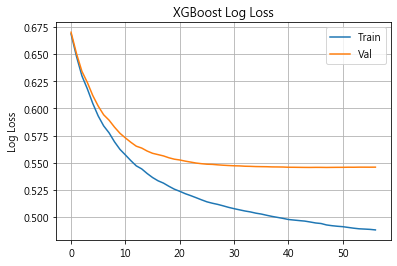

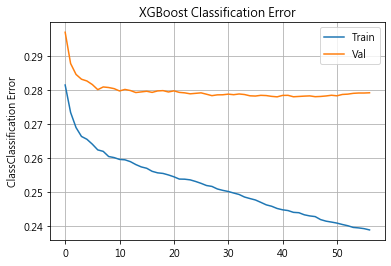

In [266]:
results = NDF_clf.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Val')
ax.legend()
plt.grid()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Val')
ax.legend()
plt.ylabel('ClassClassification Error')
plt.title('XGBoost Classification Error')
plt.grid()
plt.show()

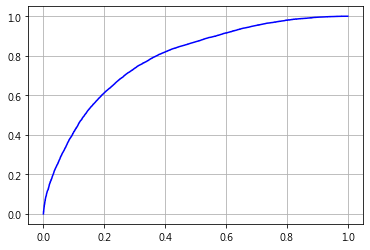

In [267]:
probs = NDF_clf.predict_proba(X_val)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_val, preds)
#roc_auc = auc(fpr, tpr)
roc_auc = roc_auc_score(y_val, preds)
plt.grid()
plt.plot(fpr, tpr, 'b', label = 'XGBoost Test AUC = %0.3f' % roc_auc)

### US_clf

In [268]:
US_train = train[train['label'] != 'NDF']
US_train = US_train.reset_index(drop=True)
US_label = US_train['label']

In [269]:
bi_labels = []
for i in range(len(US_label)):
    if US_label[i] == 'US':
        bi_labels.append('US')
    else:
        bi_labels.append('other')

In [270]:
lableE_US = LabelEncoder()
y_train = lableE_US.fit_transform(bi_labels)

In [271]:
X_train, X_val, y_train, y_val = train_test_split(US_train.iloc[:,:-1].values, y_train, test_size=0.2)

In [272]:
US_clf = XGBClassifier(max_depth=9, learning_rate=0.1, n_estimators=100,
                    objective='binary:logistic', subsample=0.6, colsample_bytree=0.6, seed=0)   

In [273]:
US_clf.fit(X_train, y_train, eval_metric=["error","logloss"], early_stopping_rounds=10, eval_set=[(X_train, y_train),(X_val,y_val)], verbose=True)

[0]	validation_0-error:0.29549	validation_0-logloss:0.675411	validation_1-error:0.301597	validation_1-logloss:0.676331
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.293634	validation_0-logloss:0.661257	validation_1-error:0.299798	validation_1-logloss:0.662694
[2]	validation_0-error:0.292875	validation_0-logloss:0.649179	validation_1-error:0.298504	validation_1-logloss:0.651579
[3]	validation_0-error:0.291497	validation_0-logloss:0.639069	validation_1-error:0.298842	validation_1-logloss:0.642665
[4]	validation_0-error:0.291975	validation_0-logloss:0.630827	validation_1-error:0.298335	validation_1-logloss:0.635298
[5]	validation_0-error:0.292664	validation_0-logloss:0.623787	validation_1-error:0.29811	validation_1-logloss:0.629173
[6]	validation_0-error:0.292537	validation_0-logloss:0.617674	validation_1-error:0.297267	validation_1-logloss:0.6241

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              silent=None, subsample=0.6, verbosity=1)

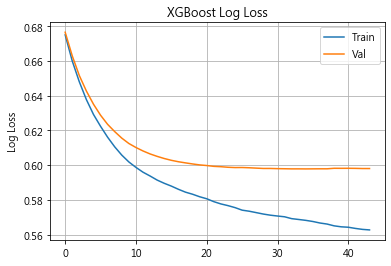

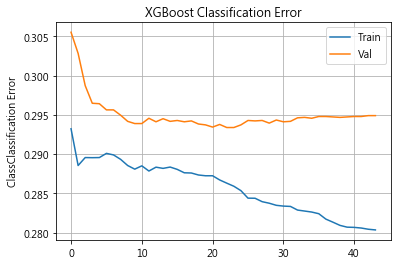

In [137]:
results = US_clf.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Val')
ax.legend()
plt.grid()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Val')
ax.legend()
plt.grid()
plt.ylabel('ClassClassification Error')
plt.title('XGBoost Classification Error')
plt.show()

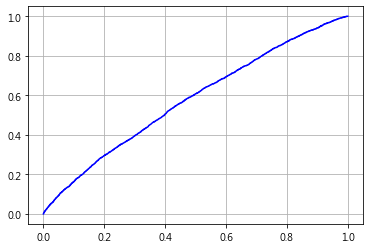

In [139]:
probs = US_clf.predict_proba(X_val)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_val, preds)
#roc_auc = auc(fpr, tpr)
roc_auc = roc_auc_score(y_val, preds)
plt.grid()
plt.plot(fpr, tpr, 'b', label = 'XGBoost Test AUC = %0.3f' % roc_auc)

## 5country_clf

In [140]:
five_train = train[train['label'].isin(['FR','IT','GB','ES','CA'])]
five_train = five_train.reset_index(drop=True)
five_label = five_train['label']

In [141]:
lableE_five = LabelEncoder()
y_train = lableE_five.fit_transform(five_label)

In [142]:
X_train, X_val, y_train, y_val = train_test_split(five_train.iloc[:,:-1].values, y_train, test_size=0.2)

In [143]:
five_clf = XGBClassifier(max_depth=12, learning_rate=0.05, n_estimators=500,
                    objective='"multi:softprob"', subsample=1, colsample_bytree=0.6, seed=1)   

In [144]:
five_clf.fit(X_train, y_train, eval_metric=["merror","mlogloss"], early_stopping_rounds=10, eval_set=[(X_train, y_train),(X_val,y_val)], verbose=True)

[0]	validation_0-merror:0.513845	validation_0-mlogloss:1.59204	validation_1-merror:0.676046	validation_1-mlogloss:1.60306
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-merror:0.484171	validation_0-mlogloss:1.57562	validation_1-merror:0.659091	validation_1-mlogloss:1.59673
[2]	validation_0-merror:0.462975	validation_0-mlogloss:1.55733	validation_1-merror:0.656566	validation_1-mlogloss:1.59154
[3]	validation_0-merror:0.459277	validation_0-mlogloss:1.54141	validation_1-merror:0.652958	validation_1-mlogloss:1.58665
[4]	validation_0-merror:0.453865	validation_0-mlogloss:1.52577	validation_1-merror:0.659812	validation_1-mlogloss:1.58193
[5]	validation_0-merror:0.448994	validation_0-mlogloss:1.51014	validation_1-merror:0.65404	validation_1-mlogloss:1.5776
[6]	validation_0-merror:0.45161	validation_0-mlogloss:1.49753	validation_1-merror:0.650794	validation_1

Stopping. Best iteration:
[55]	validation_0-merror:0.382791	validation_0-mlogloss:1.12536	validation_1-merror:0.642496	validation_1-mlogloss:1.51902



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1,
              silent=None, subsample=1, verbosity=1)

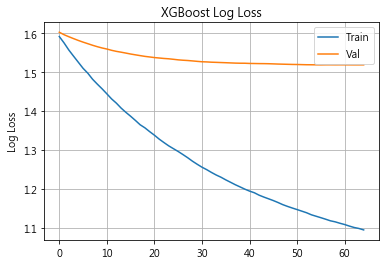

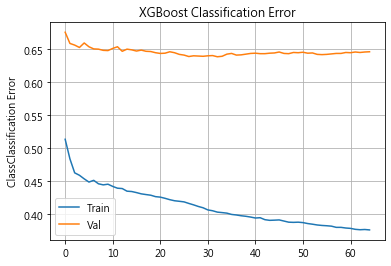

In [146]:
results = five_clf.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Val')
ax.legend()
plt.grid()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Val')
ax.legend()
plt.grid()
plt.ylabel('ClassClassification Error')
plt.title('XGBoost Classification Error')
plt.show()

## 預測結果NDF-US-other

#### NDF_clf先預測,錯的再跑US_clf

NDF

In [185]:
#change threshold
result_proba = NDF_clf.predict_proba(X_test)
ndf_pred= [1 if i > 0.6 else 0 for i in result_proba[:,1]]

In [171]:
# load the model from disk
NDF_clf14 = pickle.load(open('NDF_clf_count14.sav', 'rb'))
result_proba = NDF_clf14.predict_proba(X_test)
ndf_pred= [1 if i > 0.6 else 0 for i in result_proba[:,1]]

US

In [186]:
#change threshold
result_proba = US_clf.predict_proba(X_test)
us_pred= [1 if i > 0.63 else 0 for i in result_proba[:,1]]

Five_clf

In [187]:
result_proba = five_clf.predict_proba(X_test)

In [188]:
result_proba

array([[0.1434436 , 0.19216076, 0.24759515, 0.1439049 , 0.27289557],
       [0.10291069, 0.13396154, 0.32355312, 0.1666323 , 0.27294236],
       [0.09273226, 0.23521507, 0.33986524, 0.16681805, 0.16536936],
       ...,
       [0.08855745, 0.21557502, 0.29146105, 0.19100234, 0.21340412],
       [0.07363348, 0.09433313, 0.44819224, 0.14866936, 0.23517178],
       [0.19071922, 0.14414318, 0.2840584 , 0.17091438, 0.21016486]],
      dtype=float32)

輸出答案

In [189]:
ndf_ans = lableE_NDF.inverse_transform(ndf_pred)
us_ans = lableE_US.inverse_transform(us_pred)

In [190]:
y_pred = five_clf.predict(X_test)

In [191]:
five_ans=[]
for i in tqdm_notebook(range(len(y_pred))):
    a = list(lableE_five.inverse_transform(np.argsort(result_proba[i])))
    a.reverse()
    five_ans += a[:2]

In [192]:
ans = []
for i in range(len(test_id)):
    if ndf_ans[i] == 'NDF':
        ans.append('NDF')
        ans.append(us_ans[i])
        if us_ans[i] == 'US':
            ans.append('other')
        else:
            ans.append('US')
    else:
        ans.append(us_ans[i])
        ans.append('NDF')
        if us_ans[i] == 'US':
            ans.append('other')
        else:
            ans.append('US')
    ans.append(five_ans[i*2])
    ans.append(five_ans[i*2+1])

In [193]:
df=pd.DataFrame({'id':np.repeat(test_id,5),'country':ans})

In [180]:
df.to_csv('five_submission_count_mean.csv',index=False)

正常預測五個

In [993]:
train_d = all_data.values
X_train = train_d[:length]
X_test = train_d[length:]

In [994]:
lableE = LabelEncoder()
y_train = lableE.fit_transform(labels)

In [995]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [996]:
clf = XGBClassifier(max_depth=9, learning_rate=0.1, n_estimators=100,
                    objective='multi:softprob', subsample=1, colsample_bytree=0.6, seed=1) 

In [ ]:
clf.fit(X_train, y_train, eval_metric=["merror","mlogloss"], early_stopping_rounds=10, eval_set=[(X_train, y_train),(X_val,y_val)], verbose=True)

In [ ]:
results = clf.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Val')
ax.legend()
plt.ylabel('Multi-Class Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Val')
ax.legend()
plt.ylabel('Multi-ClassClassification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [ ]:
clf.score(X_val,y_val)

In [ ]:
y_pred = clf.predict_proba(X_test)

In [ ]:
df=pd.DataFrame({'id':[],'country':[]})
a1=[]
t_id1 = []
for i in tqdm_notebook(range(len(y_pred))):
    t_id = [test_id[i]]*5
    a = list(lableE.inverse_transform(np.argsort(y_pred[i])))[:7]
    a.reverse()
    a1 = a1+a
    t_id1 = t_id1+t_id
df2 = pd.DataFrame(np.array([t_id1, a1]).T, columns=['id','country'])
df = df.append(df2)

用答案比例來排序後直接丟進去

In [1154]:
ans = ['NDF','US','other','FR','IT']
ans = ['NDF','US']

In [1155]:
df=pd.DataFrame({'id':np.repeat(test_id,2),'country':ans*len(test_id)})

In [1156]:
df.to_csv('submission.csv',index=False)

In [195]:
best = pd.read_csv("five_submission25.csv")
best['rank']=[1,2,3,4,5]*62096
best['me'] = list(df['country'])

In [200]:
best[best['country'] != best['me']]['rank'].value_counts()

5    42198
4    26585
2     6647
1     6473
3      268
Name: rank, dtype: int64

In [213]:
best[best['country'] != best['me']]

,id,country,rank,me
4,5uwns89zht,ES,5,FR
8,jtl0dijy2j,IT,4,FR
9,jtl0dijy2j,FR,5,IT
14,xx0ulgorjt,IT,5,ES
20,czqhjk3yfe,US,1,NDF
21,czqhjk3yfe,NDF,2,US
25,szx28ujmhf,NDF,1,US
26,szx28ujmhf,US,2,NDF
28,szx28ujmhf,FR,4,IT
29,szx28ujmhf,IT,5,FR


In [219]:
best.groupby(by=['country','rank']).count()

id     me
country rank              
CA      4       647    647
        5      1959   1959
ES      4      5401   5401
        5     15841  15841
FR      4     42019  42019
        5     13323  13323
GB      4      3559   3559
        5      7596   7596
IT      4     10470  10470
        5     23377  23377
NDF     1     47235  47235
        2     14861  14861
US      1     14805  14805
        2     47067  47067
        3       224    224
other   1        56     56
        2       168    168
        3     61872  61872